Logistic-Regression: Manish Kumar Paswan

Cell 1: Environment Setup & Advanced Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Load Data
df = pd.read_csv('../diabetic_data.csv')

# 2. Handling Missing Values
# The dataset uses '?' for missing values. We convert them to NaN for standard processing.
df.replace('?', np.nan, inplace=True)

# 3. 
# We dropped 'weight' (97% missing), 'payer_code' (40% missing), and 'medical_specialty' (49% missing).
# We also drop IDs which have no predictive power.
cols_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
df.drop(columns=cols_to_drop, inplace=True)

# 4. Row-wise Cleaning
# For clinical features with very low missing counts, we drop the rows to ensure data integrity.
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)

# 5. Target Variable Refinement
# We are performing Binary Classification. 
# 'readmitted' becomes: 1 (Readmitted within or after 30 days) and 0 (No readmission).
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 6. Verification
print(f"Data Cleaning Complete. Remaining Rows: {df.shape[0]}")
print(f"Target Distribution:\n{df['readmitted'].value_counts(normalize=True)}")
df.head()

Data Cleaning Complete. Remaining Rows: 98053
Target Distribution:
readmitted
0    0.533773
1    0.466227
Name: proportion, dtype: float64


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,1


Professional Encoding and Feature Scaling

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Label Encoding Categorical Variables

le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object', 'string']).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# 2. Define Features (X) and Target (y)
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# 3. Train-Test Split (80/20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Encoding and Scaling complete.")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")

Encoding and Scaling complete.
Training features shape: (78442, 44)
Testing features shape: (19611, 44)


Logistic Regression with Cross-Validation

--- Logistic Regression Performance ---
Mean Cross-Validation Accuracy: 0.6158
Test Accuracy: 0.6138

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.79      0.69     10432
           1       0.64      0.41      0.50      9179

    accuracy                           0.61     19611
   macro avg       0.62      0.60      0.59     19611
weighted avg       0.62      0.61      0.60     19611



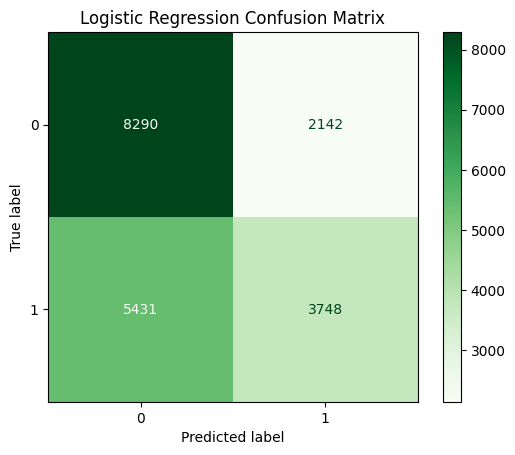

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# 1. Initialize the Model

log_reg = LogisticRegression(max_iter=3000, random_state=42)


cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)

# 3. Train on the full training set
log_reg.fit(X_train_scaled, y_train)

# 4. Evaluation
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"--- Logistic Regression Performance ---")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix Visualization
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

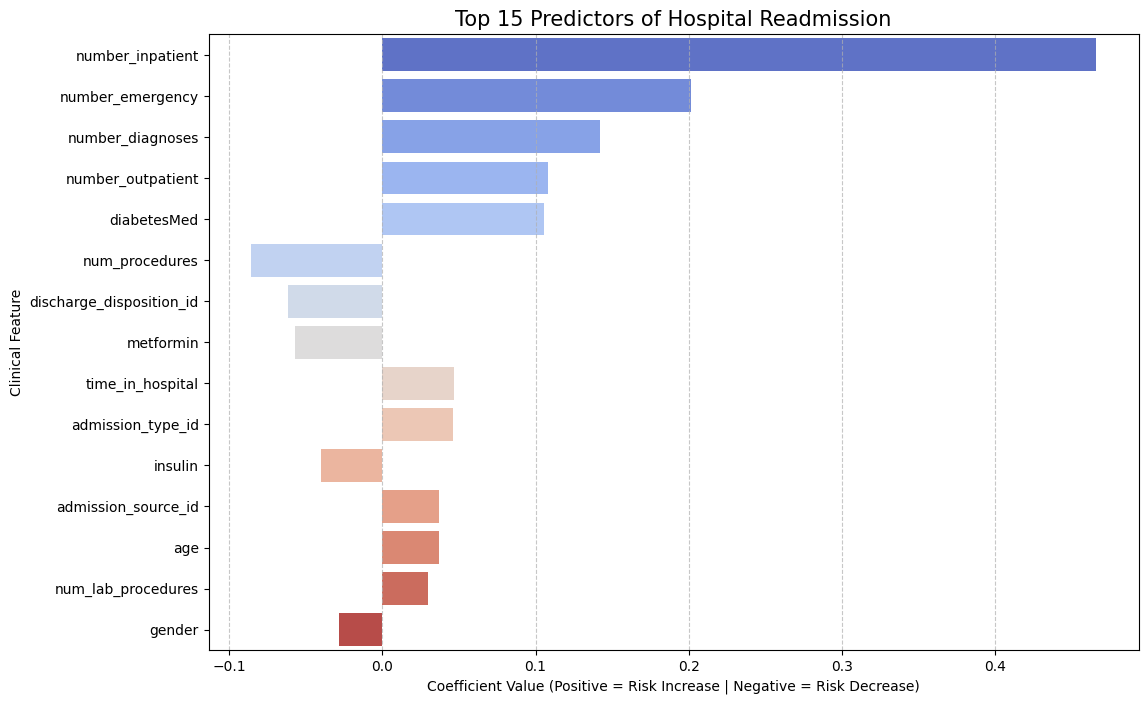

Top Clinical Risk Factor: number_inpatient


In [4]:
# Extracting and Sorting Importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Weight': log_reg.coef_[0]
})
importance['Abs_Weight'] = importance['Weight'].abs()
importance = importance.sort_values(by='Abs_Weight', ascending=False).head(15)


plt.figure(figsize=(12, 8))
sns.barplot(
    x='Weight', 
    y='Feature', 
    data=importance, 
    hue='Feature',      
    palette='coolwarm', 
    legend=False        
)
plt.title('Top 15 Predictors of Hospital Readmission', fontsize=15)
plt.xlabel('Coefficient Value (Positive = Risk Increase | Negative = Risk Decrease)')
plt.ylabel('Clinical Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Quick Insight Output
top_risk = importance[importance['Weight'] > 0]['Feature'].iloc[0]
print(f"Top Clinical Risk Factor: {top_risk}")

In [5]:
import os

# Define the results
current_model_name = "Logistic Regression" # Change this for each model folder
results_data = {
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'Recall_C1': [0.41], # Update with your actual result
    'F1_Score': [0.50]   # Update with your actual result
}

df_new_result = pd.DataFrame(results_data)


results_path = '../overall_results.csv'

if not os.path.isfile(results_path):
    df_new_result.to_csv(results_path, index=False)
else:
    # Load existing, add new, and save
    df_existing = pd.read_csv(results_path)
    # Remove old entry if we are re-running the same model
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    df_final = pd.concat([df_existing, df_new_result], ignore_index=True)
    df_final.to_csv(results_path, index=False)

print(f"Results for {current_model_name} saved to overall_results.csv")

Results for Logistic Regression saved to overall_results.csv
